In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import mdtraj as md
import pyemma

This notebook will contain the instructions to follow to build a Markov Model for the Isoleucine side chains from scratch as we have in the related publication. 

We thank the pyEmma developpers, as much of the code here comes from their package (or was slighty adapted for our purposes).

In [2]:
import pickle, copy

def save_pickle(out_path, data):
    with open(out_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as handle:
        return pickle.load(handle)

## paths in the cell below need to be adapted to point to the trajectory and topology to work with

In [3]:
# Define path to data we will work with:

root_path = '/fileserver/pine/pine2/cchampion/NMR/ubiquitin/example_traj'

top = f'{root_path}/ubq_desolv.gro'
traj = f'{root_path}/traj_4us_PBC_fit_charmm.xtc' # trajectory from gromacs 
#traj = f'{root_path}/traj_4us_PBC_fit_amber.xtc' # trajectory from gromacs 
ILE_NUM = 44

#ile_traj = f'{root_path}/ile_13.xtc' # trajectory with only the Ile13 atoms included (used to re-evaluate dihedral energies)
ile_energies = np.loadtxt(f'{root_path}/charmm_ile_energies/ile_{ILE_NUM}.xvg', comments =['@', '#'], unpack=True) # dihedral angle energies

## 1: Extract the dihedral angles from the trajectory

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Janin, Ramachandran

In [5]:
u = mda.Universe(top, traj)
r_ile = u.select_atoms(f"resname ILE and resid {ILE_NUM}")
J = Janin(r_ile).run()
dihedrals = J.results.angles[:, 0, :].T # (chi and chi2)

np.save(f'{root_path}/charmm_dihedrals/ile{ILE_NUM}_side_chain_dihedrals.npy', J.results.angles[:, 0, :].T)


KeyboardInterrupt



Save the data to a pickle / numpy array to load it more easily. To do so, uncomment next line.

In [235]:
dihedrals = np.load(f'{root_path}/charmm_dihedrals/ile{ILE_NUM}_side_chain_dihedrals.npy')

In [236]:
final_results = {}
final_results['dihedrals'] = dihedrals

## 2: Make a Markov Model in the 2-D space of $\chi_1$ and $\chi_2$

### 2.a Cluster data using energy based clustering (with periodic boundary conditions)

In [237]:
# note it is possible to play around with the hyperparameters of EBC to make sure clustering is done well! 

In [142]:
from ebc.Clustering import EBC
# can be installed with: pip install git+https://github.com/rinikerlab/EnergyBasedClustering.git

ebc = EBC(n_clusters=5, pca_components=2, temperature=5, knn=20, use_sparse=False, n_samples=5000, 
          boxsize= 360, proto_radius=5,
         )
ebc.fit(dihedrals.T, ile_energies[1:])

Using 454 proto clusters.
The gap between the two largest eigenvalues is 1.1102230246251565e-16.
Your graph might consist of multiple disconnected components which can result in unexpected behaviour.
Consider increasing the number of knn and/or the temperature.
Using the eigenvector corresponding to an eigenvalue of 0.9999999999999973.


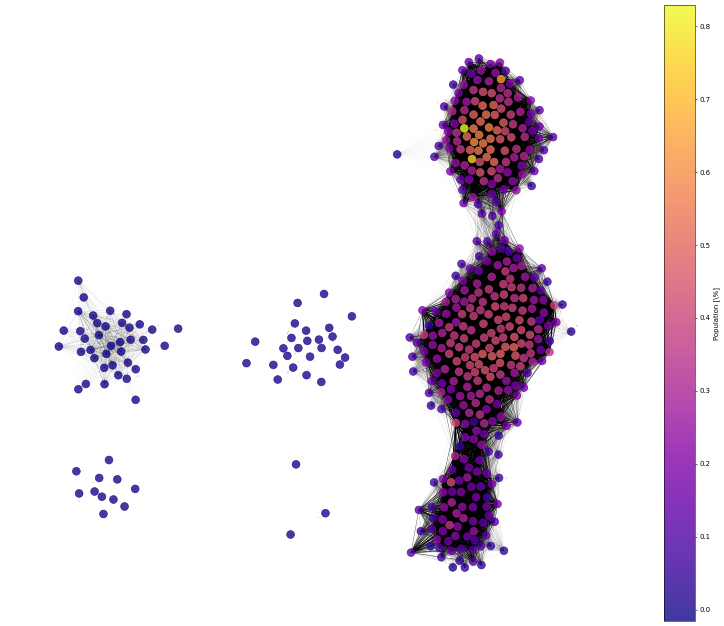

In [143]:
ebc.plot_graph(dpi=50);

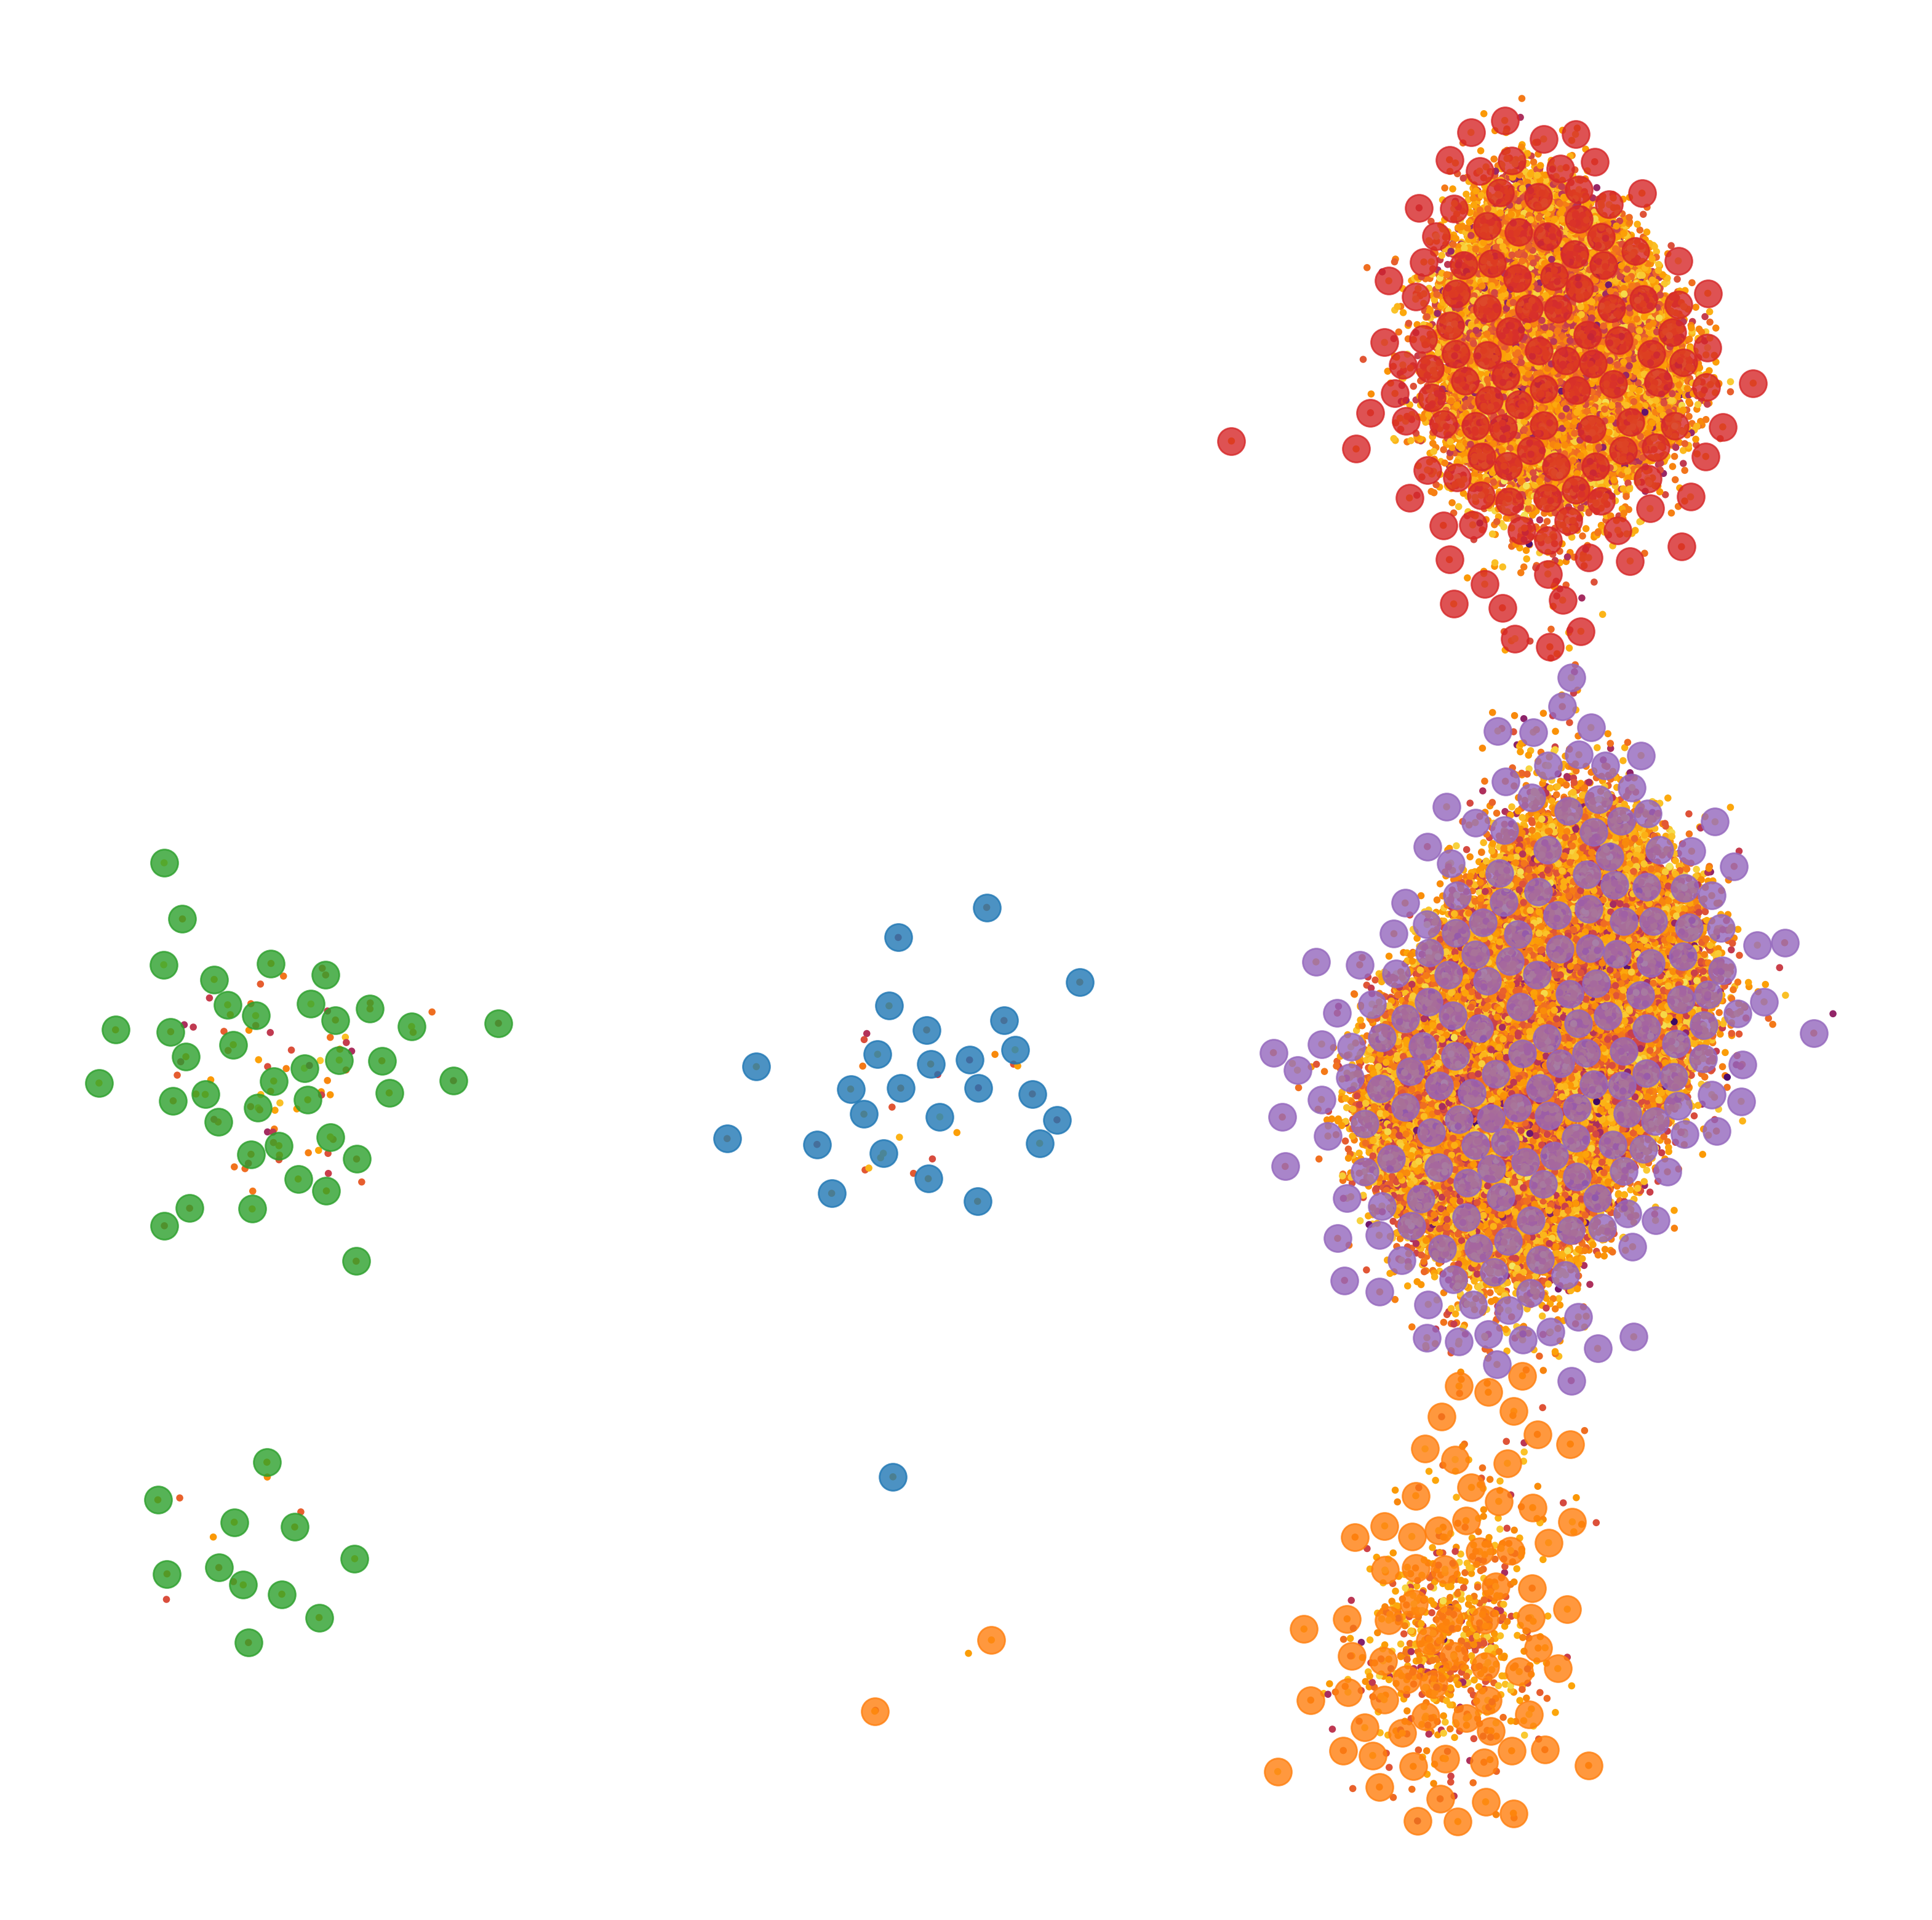

In [144]:
ebc.show();

### 2.b Map back clustering to full dataset 
clustering is done using proto-clusters for efficiency so here we map the clustering back to the full trajectory to create a discretized trajectory dtraj from which we can build a MSM

In [146]:
tmp_clusters = ebc._proto_labels

dtraj = np.zeros(len(ile_energies.T), dtype = int)

for i, (key, values) in enumerate(ebc._proto_clusters.items()):
    # keys  = cluster centers and values are all values in that proto-cluster
    dtraj[key] = tmp_clusters[i]    
    for j in values:
        dtraj[j] = tmp_clusters[i]    

### 2.c Make the Markov Model with PyEmma
As usually done with MSM building, we scan a range of lag times to make sure our implied timescales are converged

estimating BayesianMSM:   0%|                                                                                 …

15-11-23 16:35:04 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[7] WARNING  Changed user setting nits to the number of available timescales nits=4


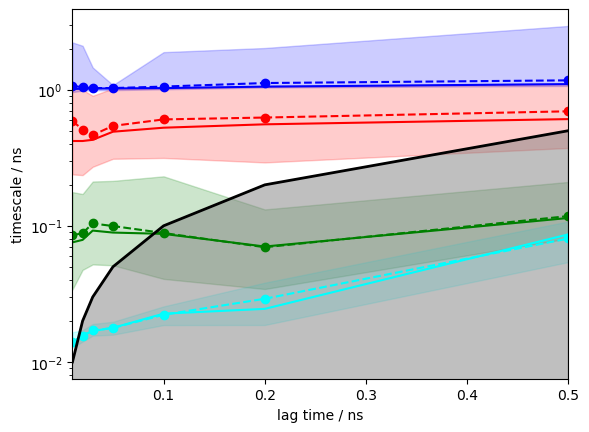

In [148]:
lags = [1, 2, 3, 5, 10, 20, 50]
its = pyemma.msm.its(dtraj, lags=lags, nits=6, errors='bayes', n_jobs=1)

outfile = f'{root_path}/charmm_plots/charmm_ile{ILE_NUM}_tlag_vs_its.pdf'
pyemma.plots.plot_implied_timescales(its, units='ns', dt=10/1000, outfile=outfile,);

In [244]:
# once we know the lag time we want to work with, we create the actual model
msm = pyemma.msm.bayesian_markov_model(dtraj, lag=5, dt_traj='0.01 ns')

pyemma.msm.estimators.bayesian_msm.BayesianMSM[8]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

In [245]:
final_results['msm'] = msm

final_results['dtraj'] = dtraj

# Save the Markov Model data to a pickle

In [248]:
path_pickle = f'{root_path}/charmm/ile{ILE_NUM}_amber.pkl'
save_pickle(path_pickle, final_results)

# Reload an MSM from a pickle (to just make plots)

In [5]:
root_path = '/fileserver/pine/pine2/cchampion/NMR/MD_and_NMR_Relaxometry/analysis/msm/data'

In [6]:
ILE_NUM = 44

#final_results = load_pickle(f'{root_path}/amber/ile{ILE_NUM}_amber.pkl')
final_results = load_pickle(f'{root_path}/charmm/ile{ILE_NUM}_charmm.pkl')
dihedrals = final_results['dihedrals']
msm = final_results['msm']
dtraj = final_results['dtraj']

In [7]:
dihedrals = final_results['dihedrals']
msm = final_results['msm']
dtraj = final_results['dtraj']

#### Compare MSM to a correlation function

In [8]:
from pyDR.MDtools import vft
from Markov2Ct import Markov2Ct

In [9]:
def markov_to_Ct_fromP(msm, dihedrals):
    """
    Compares correlation function based on the MSM with a direct correlation function 
    from the chi1/chi2 angles. 
    
    """
    dx = msm.lagtime
    dt= msm.lagtime /100 #units will be ns. We divide by 100 as trajectory printout was 10ps (so we are in ns units).

    chi1 = dihedrals[0][::dx]
    chi2 = dihedrals[1][::dx]

    state = msm.dtrajs_full[0][::dx] # overwrite with our way of doing it

    phi_tetra=np.arccos(-1/3)   #Tetrahedral angle
    
    #Bond vectors due to chi1 and chi2 motion
    v=vft.R(vft.R([0,0,1],0,phi_tetra,chi2*np.pi/180),0,phi_tetra,chi1*np.pi/180).T   
    
    m2c=Markov2Ct(tau=dt,v=v,P=msm._P, state=state)
    
    return m2c

In [10]:
m2c = markov_to_Ct_fromP(msm, dihedrals, )

amplitudes = copy.copy(m2c._A_unsorted)
cor_times = copy.copy(m2c.tc_unsorted)

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/localhome/cchampion/.conda/envs/re-eds/lib/python3.9/site-packages/pyfftw/builders/_utils.py", line 248, in _Xfftn
    FFTW_object = _FFTWWrapper(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/localhome/cchampion/.conda/envs/re-eds/lib/python3.9/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/localhome/cchampion/.conda/envs/re-eds/lib/python3.9/site-packages/pyfftw/builders/_utils.py", line 248, in _Xfftn
    FFTW_object = _FFTWWrapper(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


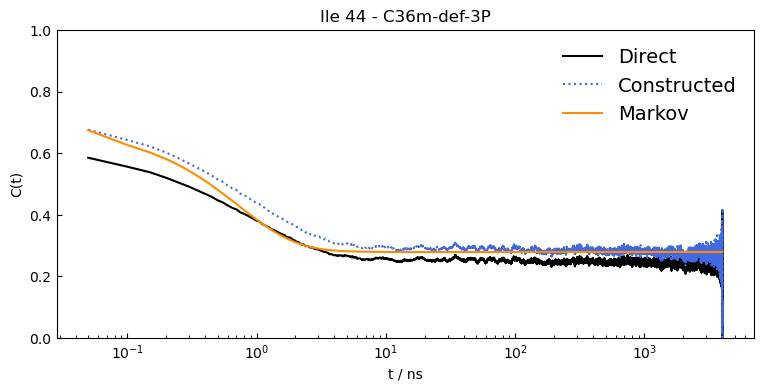

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = [9, 4])

ax=m2c.plotCt(ax)

# ax.figure.set_size_inches([9,6])
ax.set_ylim([-.1,1.1])
ax.set_xscale('log')

ax.set_ylim([0, 1])

# ax.set_title(f'Ile {ILE_NUM} - Anmr-def-3P')
ax.set_title(f'Ile {ILE_NUM} - C36m-def-3P')
ax.legend(edgecolor='white', fontsize = 14)

ax.tick_params(direction='in', axis='both', which ='both')

#fig.savefig(f'{root_path}/amber_plots/ile{ILE_NUM}_msm_ct.pdf', dpi=100)
fig.savefig(f'{root_path}/charmm_plots/ile{ILE_NUM}_msm_ct.pdf', dpi=100)

#### Extract implied timescales

In [12]:
from custom_plots import plot_its

nits = msm.neig -1

fig, axs = plot_its(msm, nits=nits)
timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

outfile = f'{root_path}/charmm_plots/charmm_ile{ILE_NUM}_its.pdf'

fig.savefig(outfile, dpi =100)

for nit in range(nits):
    print(f'{nit+1: } {round(timescales_mean[nit],1)}  \u00B1 {round(timescales_std[nit],3)} ns - {round(m2c._A_unsorted[nit], 2)} : {round(m2c.tc_unsorted[nit], 3)} ')
    
    
for nit in range(nits):
    print(f'{nit+1: } & {round(timescales_mean[nit],2)}~$\pm$~{round(timescales_std[nit],3)}  &  {round(m2c._A_unsorted[nit], 2)} \\\\')

SyntaxError: invalid syntax (custom_plots.py, line 319)

#### Inspect eigenmodes of the MSM

In [23]:
def plot_eigenmodes(msm, dihedrals, num=4):

    eigvec = msm.eigenvectors_right()
    print('The first eigenvector is one: {} (min={}, max={})'.format(
        np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))
    
    dtraj = msm.dtrajs_full[0] # works for us because we hacve a single traj
    
    
    ncol = 4 if num >= 2 else 1 
    nrow = int(np.rint(num/ncol))
    
    figsize = [4.5*ncol, 4.5*nrow]
    
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, sharex=True, sharey=True)
    for i, ax in enumerate(axes.flat):
        if i == num:
            break
        pyemma.plots.plot_contour(
            *dihedrals.T,
            eigvec[dtraj, i + 1],
            ax=ax,
            cmap='PiYG',
            cbar_label='eigenvector value'.format(i + 2),
            mask=True)
        ax.set_xlabel('chi 1')
        ax.set_ylabel('chi 2')
        ax.set_ylim([0, 360])
        ax.set_xlim([0, 360])
    fig.tight_layout()

    return fig, axes

The first eigenvector is one: True (min=0.9999999999999951, max=1.0000000000000016)


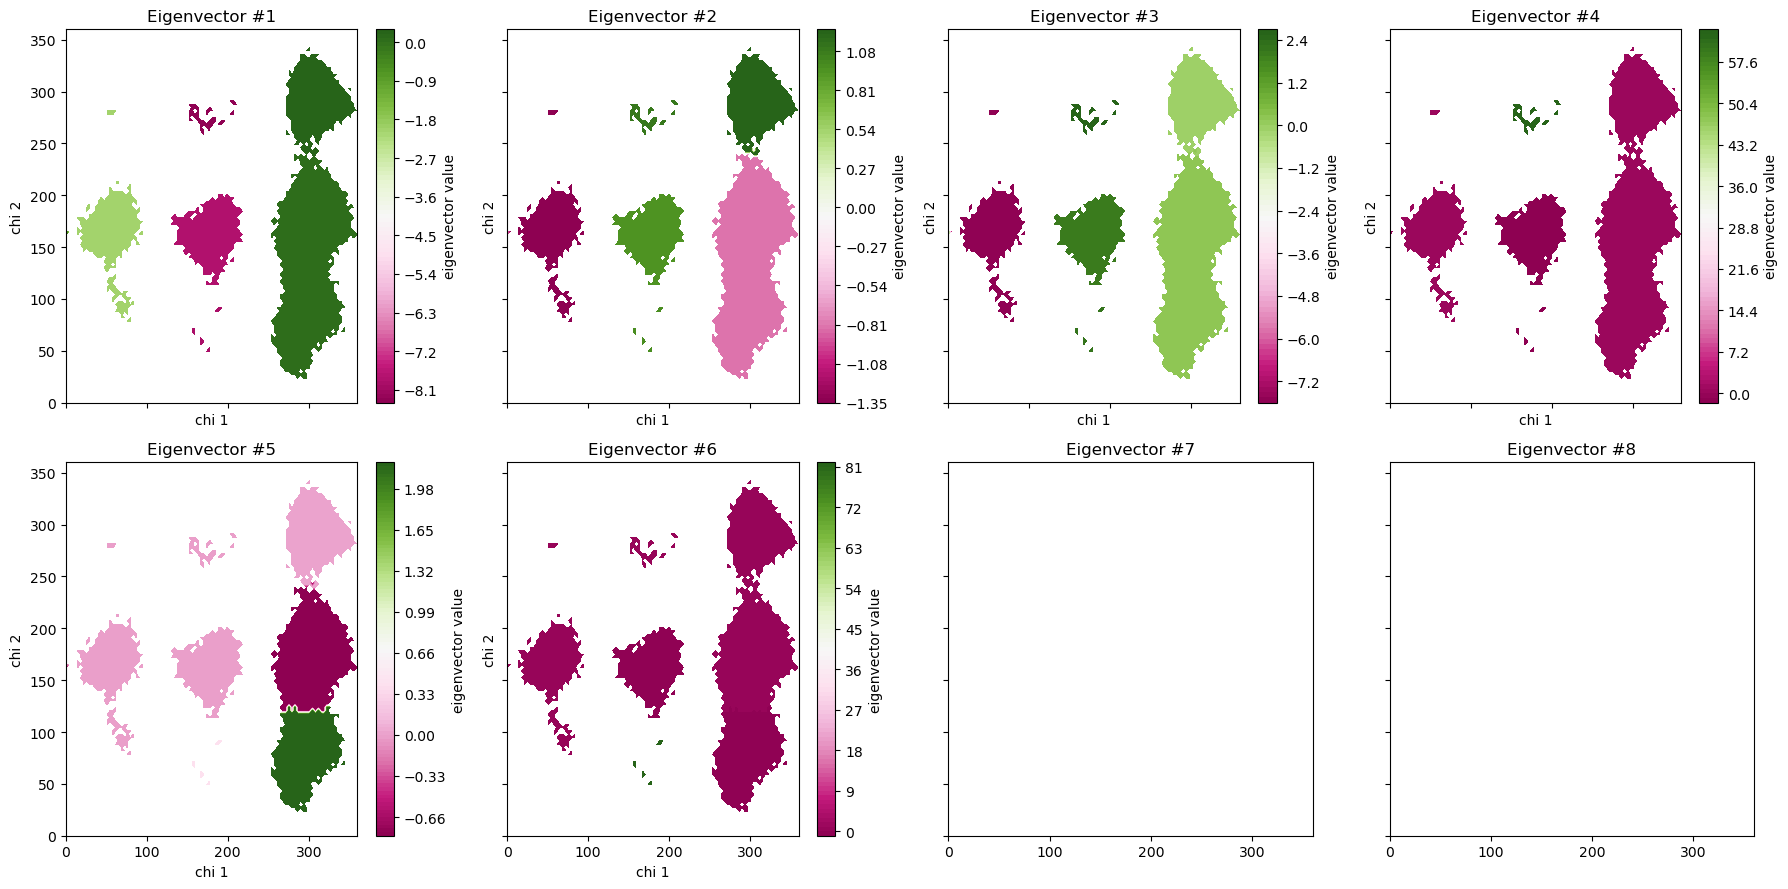

In [24]:
# import importlib
#import custom_plots

# from custom_plots import plot_eigenmodes
# It is possible to play with the number of eigenmodes to display with variable num
fig, axs = plot_eigenmodes(msm, dihedrals.T, num= msm.neig-1, )

outfile = f'{root_path}/charmm_plots/charmm_ile{ILE_NUM}_eigenvectors.pdf'
# outfile = f'{root_path}/amber_plots/amber_ile{ILE_NUM}_eigenvectors.pdf'

for i, ax in enumerate(axs.flatten()):
    ax.set_title(f'Eigenvector #{i+1}')

fig.tight_layout()
fig.savefig(outfile, dpi =100)

    

#### Metastable distribution + PCCA

state	π		G/kT
1	0.000149	8.813072
2	0.000251	8.290132
3	0.014284	4.248639
4	0.014819	4.211860
5	0.153046	1.877014
6	0.395202	0.928359
7	0.422250	0.862159


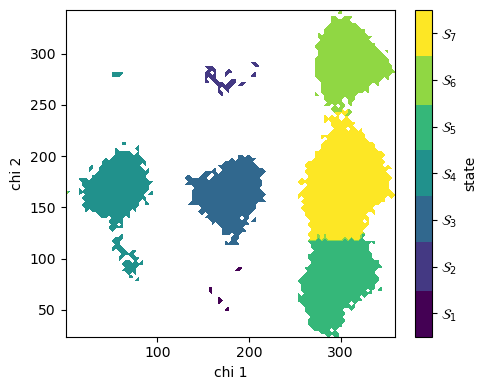

In [25]:
from custom_plots import plot_pcca, plot_metastable

# Here we keep 9 states to keep the resolution between all states so PCCA+ reclustering does "nothing", 
#but it is in principle possible to recluster to have a more coarse grained picture

nstates = np.shape(msm.P)[0]
msm.pcca(nstates) 

# fig, axes = plot_metastable(msm, dihedrals.T, ) # not always that interesting here.

pis = np.zeros(nstates)

print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    pis[i] = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, pis[i], -np.log(pis[i])))

fig, axes = plot_pcca(msm, dihedrals.T, nstates)

#### Calculation of Mean First Passage Times [MFPTs]

In [26]:
from itertools import product
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt( 
        msm.metastable_sets[i],
        msm.metastable_sets[j])
      
from pandas import DataFrame
print(f'MFPT (i > j) / [ns]:')
MPFT_df = DataFrame(np.round(mfpt, decimals=1), index=range(1, nstates + 1), columns=range(1, nstates + 1))
MPFT_df

# read as from (row id) towards (col id)

MFPT (i > j) / [ns]:


,1,2,3,4,5,6,7
1,0.0,593.6,1.7,15.3,2.5,4.0,2.3
2,339.9,0.0,2.8,14.7,2.6,4.1,2.4
3,340.1,594.9,0.0,14.9,2.5,3.9,2.2
4,435.5,688.5,96.6,0.0,1.2,2.7,1.0
5,458.4,712.1,119.9,36.9,0.0,1.9,0.1
6,459.5,713.2,121.0,38.1,1.5,0.0,1.3
7,458.4,712.1,119.9,36.9,0.4,1.9,0.0


In [27]:
def print_as_latex(MPFT_df):
    """
    Prints the dataframe in Latex format so it can be copied to the SI
    
    """
    
    def format_string(v):
        if v == '-':
            return v
        if float(v) >= 10:
            return f'{v:.0f}'
        else:
            return f'{v:.1f}'
    
    n = (len(MPFT_df))
    print ('\\begin{tabular}{|' + 'l|'*(n+1) +'}')
    print ('\hline')
    print ( ' &', end = ' ')
    for i in range(1, n+1):
        if i == n:
            print (str(i), end = ' ')
        else:
            print (str(i) +' &', end = ' ')
    print ('\\\\\n\hline\hline')
    
    for i, row in MPFT_df.iterrows():
        print (str(i) + ' &', end = ' ')
        l = len(row)
        #print (f'{l=}')
        for k, v in enumerate(np.array(row)):
            if v == 0.0:
                v = '-'
            
            if l == k+1:
                print (format_string(v), end = ' ')
            else:
                print (format_string(v) +' &', end = ' ')
        print ('\\\\')
        print ('\hline')
    print('\end{tabular}')
    print('\end{table}')

In [28]:
print_as_latex(MPFT_df)

\begin{tabular}{|l|l|l|l|l|l|l|l|}
\hline
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
\hline\hline
1 & - & 594 & 1.7 & 15 & 2.5 & 4.0 & 2.3 \\
\hline
2 & 340 & - & 2.8 & 15 & 2.6 & 4.1 & 2.4 \\
\hline
3 & 340 & 595 & - & 15 & 2.5 & 3.9 & 2.2 \\
\hline
4 & 436 & 688 & 97 & - & 1.2 & 2.7 & 1.0 \\
\hline
5 & 458 & 712 & 120 & 37 & - & 1.9 & 0.1 \\
\hline
6 & 460 & 713 & 121 & 38 & 1.5 & - & 1.3 \\
\hline
7 & 458 & 712 & 120 & 37 & 0.4 & 1.9 & - \\
\hline
\end{tabular}
\end{table}


In [20]:
from custom_plots import plot_msm_final, plot_msm_final2

In [ ]:
metastable_traj = msm.metastable_assignments[dtraj]

# Set the colors, + make sure the coloring is always the same when we count from the most-populated cluster
# regardless of the number of clusters
colors = ['#284E60', '#F99B45', '#D95980', '#59CD90', '#946126', 'cornflowerblue', 'purple', 'yellow', 'black']
colors = colors[:max(msm.metastable_assignments)+1][::-1]

fig, ax, contours  = plot_msm_final2(dihedrals, metastable_traj, 
                          alpha = 0.95, title = f'Isoleucine 44 - Markov Model', colors=colors, 
                          with_leg = True
                         )

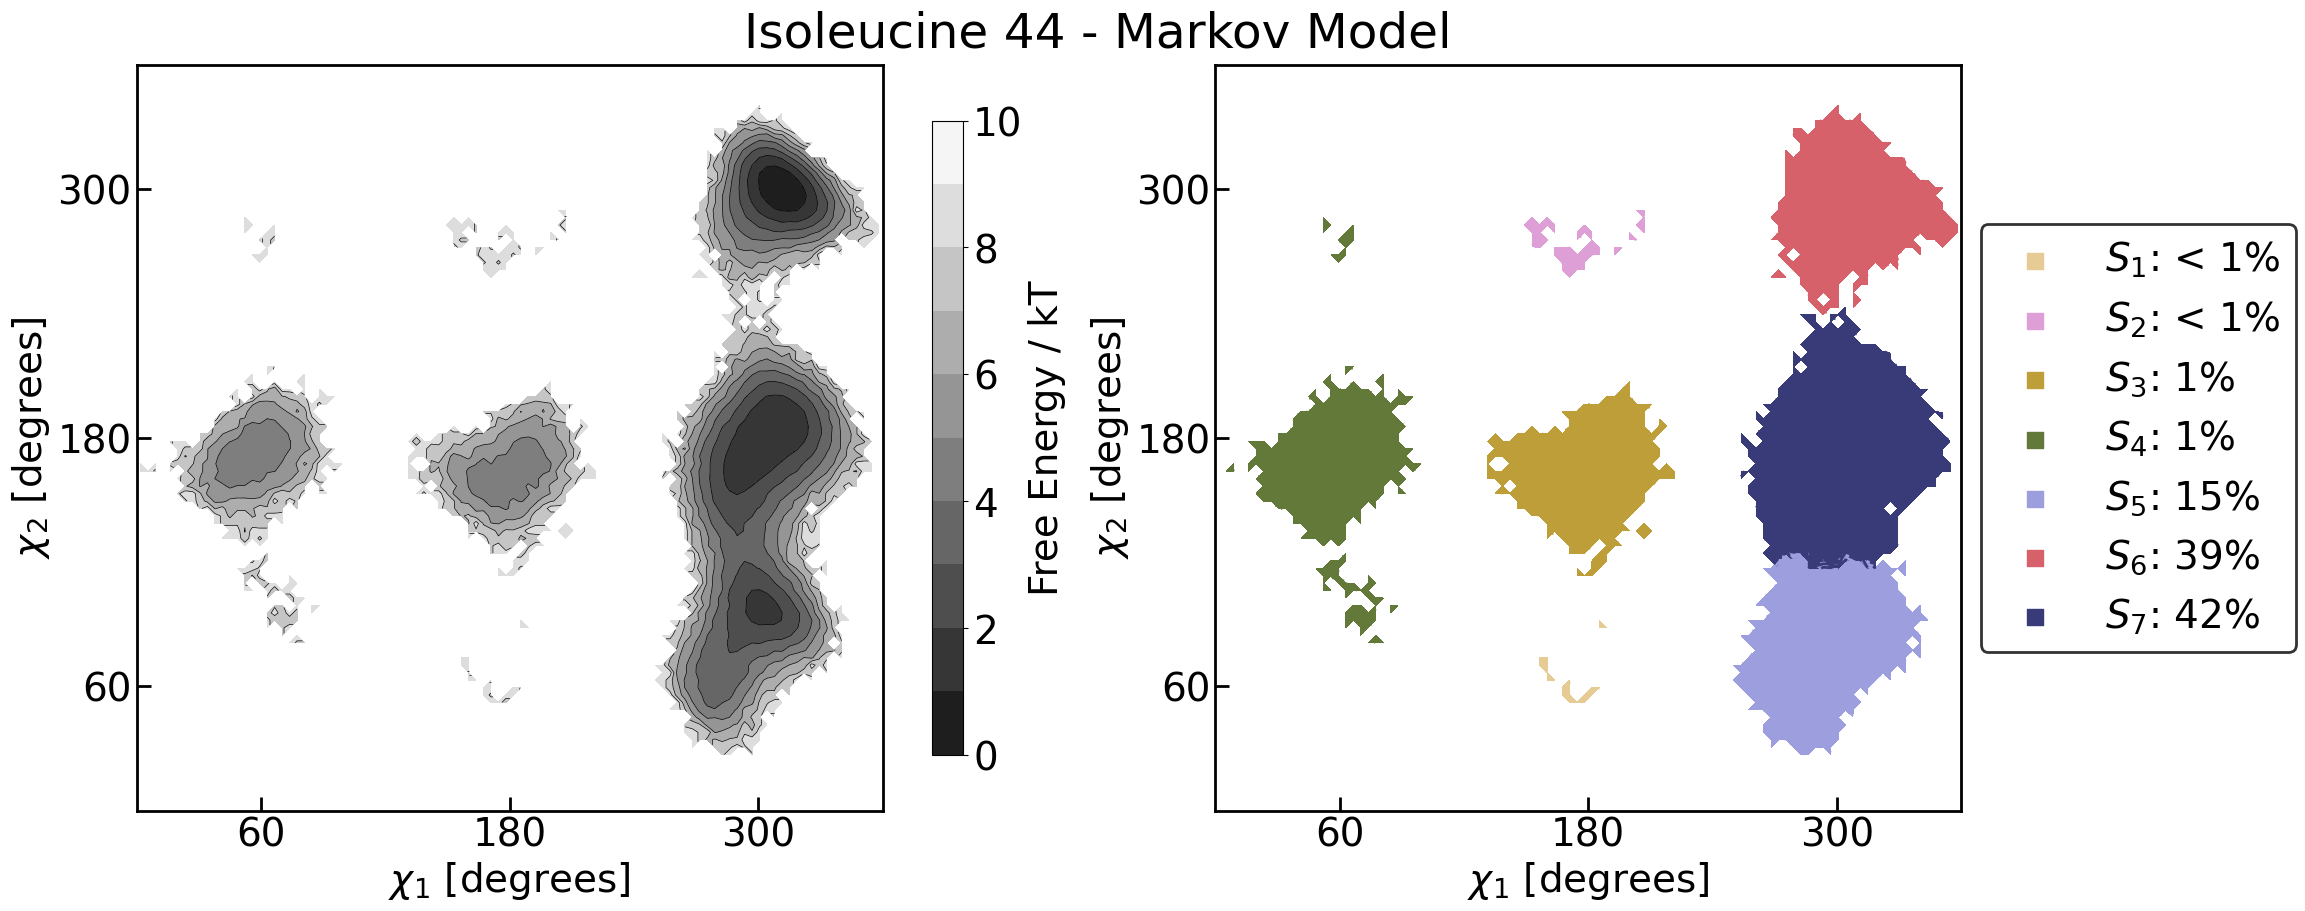

In [31]:
metastable_traj = msm.metastable_assignments[dtraj]

fig, ax, contours  = plot_msm_final2(dihedrals, metastable_traj, 
                          alpha = 0.95, title = f'Isoleucine 44 - Markov Model',
                          with_leg = True
                         )